In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
raw_data = pd.read_csv('/content/drive/MyDrive/malicious_phish.csv')
raw_data.sample(10)

,url,type
495410,election-montreal.qc.ca/cadre-electoral-distri...,benign
298746,realestate.oodle.com/ordway-co/?o=25,benign
636693,www.kate.net/holidays/halloween/wallpaper.html,phishing
239171,en.wikipedia.org/wiki/Dalia_Dorner,benign
416248,eforu.com/birthdays/September_17.html,benign
464365,freebase.com/view/en/mountain_view_cemetery,benign
453793,hud-homes-in-oakland-ca.info/,benign
48589,http://www.apostlescampingpark.com.au/index.ph...,defacement
190992,tvlistings.zap2it.com/tv/the-penguins-of-madag...,benign
173356,montreal.about.com/od/montrealevents/a/fantasi...,benign


In [4]:
df = raw_data['type'].apply(lambda x: 0 if x == 'benign' else 1)
df = pd.concat([df, raw_data['url']], axis=1)
df.sample(10)

,type,url
294348,1,http://patrikcase.com/index.php?option=com_vir...
279851,0,isu.edu/bios/theses_dissertations.shtml
21329,0,blueprintlaw.com.au/content/readmorepage/infob...
289670,0,wn.com/old_National_Road
438027,0,http://emgn.com/entertainment/meet-the-new-kin...
610195,1,www.greenamericatoday.org/pubs/realgreen/
428494,1,http://crisantocirugiaplastica.com/index.php?o...
227652,0,censusonline.us/browse/STROUSE/
408604,0,tammieoliver.com/features/the-murder-of-precio...
523029,1,https://perdoesdiesel.com.br/attached/Sarver/


In [5]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

In [15]:
class Trainer:
  def __init__(
      self,
      lr=5e-5,
      train_batch_size=64,
      valid_batch_size=16,
      epoch=10,
      shuffle=True,
      truncation=True,
      padding=True,
      max_length=512,
      accumulation_steps=4,
      label_name='type',
      column_name='url',
      checkpoint_path='checkpoint',
      patience=3,
      min_delta=0.001
  ):

    #self.tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    #self.model = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=2)
    self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    self.model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    self.lr = lr
    self.train_batch_size = train_batch_size
    self.valid_batch_size = valid_batch_size
    self.epoch = epoch
    self.shuffle = shuffle
    self.truncation = truncation
    self.padding = padding
    self.max_length = max_length
    self.accumulation_steps = accumulation_steps
    self.patience = patience
    self.min_delta = min_delta

    self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model.to(self.device)

    self.label_name=label_name
    self.column_name=column_name

    self.scaler = GradScaler()

    self.train_losses = []
    self.val_losses = []
    self.val_accuracies = []

    self.checkpoint_path = checkpoint_path
    if not os.path.exists(self.checkpoint_path):
      os.makedirs(self.checkpoint_path)

  class URLDataset(Dataset):
    def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def prepare_data(self, ds):
    urls = ds[self.column_name].tolist()
    labels = ds[self.label_name].tolist()
    encodings = self.tokenizer(
      urls,
      truncation=self.truncation,
      padding=self.padding,
      max_length=self.max_length,
      return_tensors="pt"
    )
    return self.URLDataset(encodings, labels)

  def train(self, dataset, val_dataset=None):

    dataloader = DataLoader(dataset, batch_size=self.train_batch_size, shuffle=self.shuffle, num_workers=4, pin_memory=True)
    if val_dataset:
      val_dataloader = DataLoader(val_dataset, batch_size=self.valid_batch_size, shuffle=self.shuffle, num_workers=4, pin_memory=True)
      best_loss = float('inf')
      patience_counter = 0
    else:
      val_dataloader = None

    self.model.train()

    for e in range(self.epoch):
      epoch_loss = 0
      self.optimizer.zero_grad()

      for i, batch in enumerate(tqdm(dataloader, desc=f"Training Epoch {e+1}/{self.epoch}")):
        batch = {k: v.to(self.device) for k, v in batch.items()}

        with autocast():
          outputs = self.model(**batch)
          loss = outputs.loss
          loss = loss / self.accumulation_steps

        self.scaler.scale(loss).backward()

        if (i+1) % self.accumulation_steps == 0:
          self.scaler.step(self.optimizer)
          self.scaler.update()
          self.optimizer.zero_grad()

        epoch_loss += loss.item() * self.accumulation_steps

      avg_loss = epoch_loss / len(dataloader)
      self.train_losses.append(avg_loss)

      if self.checkpoint_path:
        checkpoint_dir = os.path.join(self.checkpoint_path, f"epoch_{e+1}")
        torch.save(self.model.state_dict(), checkpoint_dir)

      if val_dataloader:
        val_loss = self.validate(val_dataloader)

        if val_loss < best_loss - self.min_delta:
          best_loss = val_loss
          patience_counter = 0
        else:
          patience_counter += 1

        if patience_counter >= self.patience:
          print(f"Early stopping at epoch {e+1}")
          break

      print(f"Epoch: {e+1}/{self.epoch}, Loss: {avg_loss}")

    self.draw_learning_curve()

  def validate(self, val_dataloader):
    self.model.eval()
    eval_loss = 0
    corrects = 0
    total = 0

    with torch.no_grad():
      for batch in tqdm(val_dataloader, desc="Validating"):
        batch = {k: v.to(self.device) for k, v in batch.items()}

        outputs = self.model(**batch)
        loss = outputs.loss
        eval_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        labels = batch['labels']

        corrects += torch.sum(preds == labels).item()
        total += len(labels)

    avg_loss = eval_loss / len(val_dataloader)
    accuracy = corrects / total

    self.val_losses.append(avg_loss)
    self.val_accuracies.append(accuracy)

    print(f"Validation Loss: {avg_loss}, Accuracy: {accuracy}")
    self.model.train()

    return avg_loss

  def evaluate(self, dataset):

    dataloader = DataLoader(dataset, batch_size=self.valid_batch_size, num_workers=4, pin_memory=True)
    self.model.eval()

    labels = []
    preds = []

    with torch.no_grad():
      for batch in tqdm(dataloader, desc="Evaluating"):
        batch = {k: v.to(self.device) for k, v in batch.items()}

        outputs = self.model(**batch)
        logits = outputs.logits

        pred = torch.argmax(logits, dim=-1)
        preds.extend(pred.cpu().numpy())
        labels.extend(batch['labels'].cpu().numpy())

    print(classification_report(labels, preds))
    accuracy = accuracy_score(labels, preds)
    conf_matrix = confusion_matrix(labels, preds)
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")

  def draw_learning_curve(self):

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(self.train_losses, label='Training Loss')
    plt.plot(self.val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(self.val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()

    plt.tight_layout()
    plt.show()

  def save(self, path):
    if not os.path.exists(path):
      os.makedirs(path)
    self.model.save_pretrained(path)
    self.tokenizer.save_pretrained(path)

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, stratify=df['type'], shuffle=True)
train, val = train_test_split(train, test_size=0.2, stratify=train['type'], shuffle=True)

In [17]:
model_path = '/content/drive/MyDrive/url-detection/v2/'

In [18]:
trainer = Trainer(
  epoch=30,
  train_batch_size=128,
  valid_batch_size=32,
  accumulation_steps=4,
  lr=5e-5,
  checkpoint_path=model_path+'checkpoints'
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
train_dataset = trainer.prepare_data(train)
val_dataset = trainer.prepare_data(val)

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

Validating: 100%|██████████| 3256/3256 [05:59<00:00,  9.04it/s]


Validation Loss: 0.030787468208528866, Accuracy: 0.9892793043545028
Epoch: 1/30, Loss: 0.059791783829384396


Validating: 100%|██████████| 3256/3256 [05:59<00:00,  9.05it/s]


Validation Loss: 0.03212064397769517, Accuracy: 0.9902870689406954
Epoch: 2/30, Loss: 0.025494600951680754


Validating: 100%|██████████| 3256/3256 [05:59<00:00,  9.05it/s]


Validation Loss: 0.02845742015950089, Accuracy: 0.9909589119981572
Epoch: 3/30, Loss: 0.015449423264856255


Validating: 100%|██████████| 3256/3256 [05:59<00:00,  9.05it/s]


Validation Loss: 0.030857629160098227, Accuracy: 0.9905654039216439
Epoch: 4/30, Loss: 0.008546051344747315


Validating: 100%|██████████| 3256/3256 [05:59<00:00,  9.05it/s]


Validation Loss: 0.043248784563041445, Accuracy: 0.9904790240999702
Epoch: 5/30, Loss: 0.005438411867752167


Validating: 100%|██████████| 3256/3256 [05:59<00:00,  9.06it/s]


Validation Loss: 0.0471300251928993, Accuracy: 0.9900183317177107
Early stopping at epoch 6


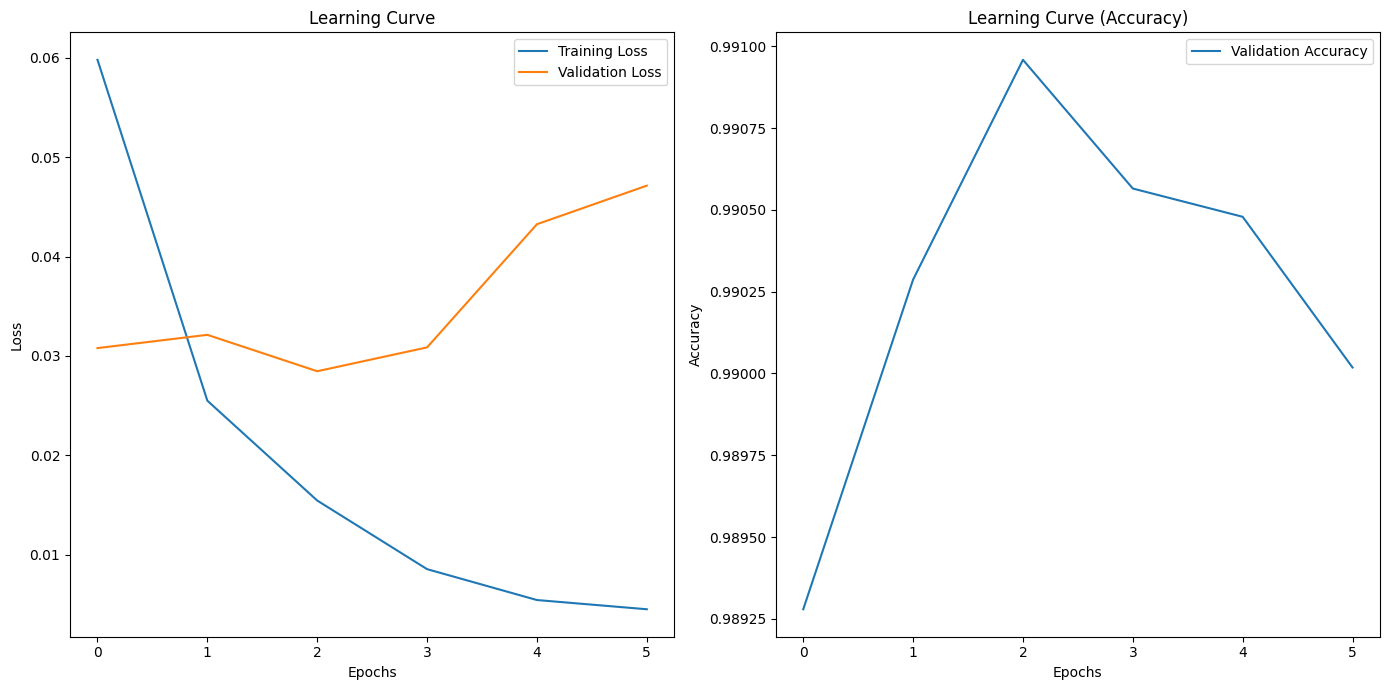

In [21]:
trainer.train(train_dataset, val_dataset)

In [22]:
trainer.save(model_path+'model')

In [23]:
test_dataset = trainer.prepare_data(test)

In [24]:
trainer.evaluate(test_dataset)

Evaluating: 100%|██████████| 4070/4070 [07:29<00:00,  9.04it/s]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     85621
           1       0.99      0.98      0.99     44618

    accuracy                           0.99    130239
   macro avg       0.99      0.99      0.99    130239
weighted avg       0.99      0.99      0.99    130239

Accuracy: 0.9901028109859565
Confusion Matrix:
[[85148   473]
 [  816 43802]]


In [34]:
checkpoint_path = '/content/drive/MyDrive/url-detection/v2/checkpoints/epoch_3'

In [35]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.load_state_dict(torch.load(checkpoint_path))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [36]:
save_path = '/content/drive/MyDrive/url-detection/v2.1/model'

In [37]:
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/url-detection/v2.1/model/tokenizer_config.json',
 '/content/drive/MyDrive/url-detection/v2.1/model/special_tokens_map.json',
 '/content/drive/MyDrive/url-detection/v2.1/model/vocab.txt',
 '/content/drive/MyDrive/url-detection/v2.1/model/added_tokens.json')

In [39]:
model.eval()

labels = []
preds = []

dataloader = DataLoader(test_dataset, batch_size=256, num_workers=4, pin_memory=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

with torch.no_grad():
  for batch in tqdm(dataloader, desc="Evaluating"):
    batch = {k: v.to(device) for k, v in batch.items()}

    outputs = model(**batch)
    logits = outputs.logits

    pred = torch.argmax(logits, dim=-1)
    preds.extend(pred.cpu().numpy())
    labels.extend(batch['labels'].cpu().numpy())

print(classification_report(labels, preds))
accuracy = accuracy_score(labels, preds)
conf_matrix = confusion_matrix(labels, preds)
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Evaluating: 100%|██████████| 509/509 [07:03<00:00,  1.20it/s]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     85621
           1       0.99      0.98      0.99     44618

    accuracy                           0.99    130239
   macro avg       0.99      0.99      0.99    130239
weighted avg       0.99      0.99      0.99    130239

Accuracy: 0.9906556407834827
Confusion Matrix:
[[85088   533]
 [  684 43934]]
